# JNB Model

## Purpose

The purpose of this file is to create a model to predict temp. at JNB. This notebook will also serve as a "test" or "skeleton" for other models. 

## Variables of Interest

'CAPE 180-0 mb above gnd', 'Cloud Cover Total sfc', 'Diffuse Shortwave Radiation sfc', 'Direct Shortwave Radiation sfc', 'Evapotranspiration sfc', 'FAO Reference Evapotranspiration 2 m', 'Shortwave Radiation sfc', 'Vapor Pressure Deficit 2 m'

These variables were found to be predictive of temp. in a random forest analysis. 

## Load Packages

In [ ]:
import os
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import RobustScaler
#from pathlib import Path
import sys
import json

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Set Paths to Data if on local

If on Colab upload the csv file to the files bar on left hand side.

`target_city` is which city you want to analyze 

`data_folder` is where you have the extracted --> combined folder stored on your local

In [ ]:
target_city = 'JNB' # set which city we want to analyze
file_type = '.csv'
data_folder = '/Users/JamesGuoLunWen/Desktop/22S/Supply Chain/StarterCode/extracted/combined/'
file = data_folder + target_city + file_type

print(file)

/Users/JamesGuoLunWen/Desktop/22S/Supply Chain/StarterCode/extracted/combined/JNB.csv


## Load and Clean the Data

In [ ]:
#df = pd.read_csv(file) # if on local
df = pd.read_csv(target_city + file_type) # if on colab
df["dt"] = pd.to_datetime(df["dt"])
df = df[(df["dt"].dt.year > 2008) & (df["dt"].dt.year < 2021)]

df = df[["dt", "Temperature", 'CAPE 180-0 mb above gnd', 'Cloud Cover Total sfc', 
         'Diffuse Shortwave Radiation sfc', 'Direct Shortwave Radiation sfc', 
         'Evapotranspiration sfc', 'FAO Reference Evapotranspiration 2 m', 
         'Shortwave Radiation sfc', 'Vapor Pressure Deficit 2 m']]
date_time = pd.to_datetime(df.pop("dt"))

In [ ]:
df.head()

,Temperature,CAPE 180-0 mb above gnd,Cloud Cover Total sfc,Diffuse Shortwave Radiation sfc,Direct Shortwave Radiation sfc,Evapotranspiration sfc,FAO Reference Evapotranspiration 2 m,Shortwave Radiation sfc,Vapor Pressure Deficit 2 m
210384,-2.40,0.0,12.0,0.0,0.0,0.00144,0.000526,0.0,1.583182
210385,-2.74,0.0,1.0,0.0,0.0,0.00000,0.000000,0.0,1.384841
210386,-3.04,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,1.242771
210387,-3.29,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,1.167292
210388,-1.63,0.0,1.0,0.0,0.0,0.00000,0.000000,0.0,0.830545


In [ ]:
date_time.head()

210384   2009-01-01 00:00:00
210385   2009-01-01 01:00:00
210386   2009-01-01 02:00:00
210387   2009-01-01 03:00:00
210388   2009-01-01 04:00:00
Name: dt, dtype: datetime64[ns]

In [ ]:
df = df.set_index(pd.DatetimeIndex(date_time)).reset_index()
df['Year'] = df['dt'].dt.year

df['MonthNumber'] = df['dt'].dt.month
# convert week 53 into week 52, not all years have 53 weeks so we are just going to average week 53 into week 52
#df['WeekNumber'] = [52 if df['WeekNumber'][row] == 53 else df['WeekNumber'][row] for row in range(len(df))]
max_months = df['MonthNumber'].max()
print(max_months)
df['month_sin'] = np.sin(2 * np.pi * df['MonthNumber'] / max_months)
df['month_cos'] = np.cos(2 * np.pi * df['MonthNumber'] / max_months)

df['Hour'] = df['dt'].dt.hour
max_hours = df['Hour'].max()
df['hour_sin'] = np.sin(2 * np.pi * df['Hour'] / max_hours)
df['hour_cos'] = np.cos(2 * np.pi * df['Hour'] / max_hours)

df.head()

12


,dt,Temperature,CAPE 180-0 mb above gnd,Cloud Cover Total sfc,Diffuse Shortwave Radiation sfc,Direct Shortwave Radiation sfc,Evapotranspiration sfc,FAO Reference Evapotranspiration 2 m,Shortwave Radiation sfc,Vapor Pressure Deficit 2 m,Year,MonthNumber,month_sin,month_cos,Hour,hour_sin,hour_cos
0,2009-01-01 00:00:00,15.58,580.0,0.9,0.00000,0.00000,0.00288,0.010384,0.00,3.148837,2009,1,0.5,0.866025,0,0.000000,1.000000
1,2009-01-01 01:00:00,14.88,550.0,14.0,0.00000,0.00000,0.00144,0.000146,0.00,1.778025,2009,1,0.5,0.866025,1,0.269797,0.962917
2,2009-01-01 02:00:00,14.32,435.0,23.0,0.00000,0.00000,0.00000,0.000000,0.00,0.855408,2009,1,0.5,0.866025,2,0.519584,0.854419
3,2009-01-01 03:00:00,14.04,271.0,17.0,0.00000,0.00000,0.00000,0.000000,0.00,0.501471,2009,1,0.5,0.866025,3,0.730836,0.682553
4,2009-01-01 04:00:00,17.16,238.0,22.0,16.03519,17.78481,0.00000,0.010209,33.82,1.825266,2009,1,0.5,0.866025,4,0.887885,0.460065


In [ ]:
print(len(df))

105192


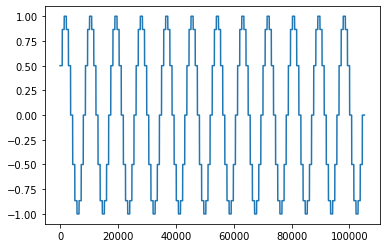

In [ ]:
df['month_sin'].plot()

In [ ]:
historic_interval = pd.DataFrame()
#for year in range(2021 - math.floor(len(df) / (365 * 24)), 2020):
for year in range(df.Year.min(), df.Year.max() + 1):
    for month in range(df.MonthNumber.min(), df.MonthNumber.max() + 1):
        for hour in range(df.Hour.min(), df.Hour.max() + 1):
            points = df.loc[
                (df['Hour'] == hour)
                & (df['MonthNumber'] == month)
                & (df['Year'] == year)
            ]

            historic_interval = historic_interval.append(
                {
                    "Temp_Mean": points["Temperature"].mean(),
                    "CAPE 180-0 mb above gnd_Mean": points["CAPE 180-0 mb above gnd"].mean(),
                    "Cloud Cover Total sfc_Mean": points["Cloud Cover Total sfc"].mean(),
                    "Diffuse Shortwave Radiation sfc_Mean": points["Diffuse Shortwave Radiation sfc"].mean(),
                    "Direct Shortwave Radiation sfc_Mean": points["Direct Shortwave Radiation sfc"].mean(),
                    "Evapotranspiration sfc_Mean": points["Evapotranspiration sfc"].mean(),
                    "FAO Reference Evapotranspiration 2 m_Mean": points["FAO Reference Evapotranspiration 2 m"].mean(),
                    "Shortwave Radiation sfc_Mean": points["Shortwave Radiation sfc"].mean(),
                    "Vapor Pressure Deficit 2 m_Mean": points["Vapor Pressure Deficit 2 m"].mean(),
                    "Year": points["Year"].mean(),
                    "month_sin": points["month_sin"].mean(),
                    "month_cos": points["month_cos"].mean(),
                    "hour_sin": points["hour_sin"].mean(),
                    "hour_cos": points["hour_cos"].mean(),
                },
                ignore_index=True,
            )

historic_interval.head(5)

,Temp_Mean,CAPE 180-0 mb above gnd_Mean,Cloud Cover Total sfc_Mean,Diffuse Shortwave Radiation sfc_Mean,Direct Shortwave Radiation sfc_Mean,Evapotranspiration sfc_Mean,FAO Reference Evapotranspiration 2 m_Mean,Shortwave Radiation sfc_Mean,Vapor Pressure Deficit 2 m_Mean,Year,month_sin,month_cos,hour_sin,hour_cos
0,16.960968,426.903226,49.835484,0.000000,0.000000,0.004320,0.011107,0.000000,3.982399,2009.0,0.5,0.866025,0.000000,1.000000
1,16.570323,437.161290,51.935484,0.000000,0.000000,0.003670,0.008620,0.000000,3.471393,2009.0,0.5,0.866025,0.269797,0.962917
2,16.148710,435.451613,54.570968,0.000000,0.000000,0.003345,0.006014,0.000000,2.981105,2009.0,0.5,0.866025,0.519584,0.854419
3,15.729677,443.129032,55.761290,0.000000,0.000000,0.002973,0.003406,0.000000,2.450826,2009.0,0.5,0.866025,0.730836,0.682553
4,17.224839,424.032258,51.870968,5.662908,6.509995,0.005017,0.002500,12.172903,2.222885,2009.0,0.5,0.866025,0.887885,0.460065


## Look for NA values in our historic_interval dataframe

In [ ]:
na_list = historic_interval[historic_interval['Year'].isnull()].index.tolist()
print(len(na_list))

0


In [ ]:
time = pd.DataFrame()
#for year in range(2021 - math.floor(len(df) / (365 * 24)), 2020):
for year in range(df.Year.min(), df.Year.max() + 1):
    for week in range(df.WeekNumber.min(), df.WeekNumber.max() + 1):
        for hour in range(df.Hour.min(), df.Hour.max() + 1):
            

            time = time.append(
                {
                    "Year": year,
                    "Week": week,
                    "Hour": hour,
                },
                ignore_index=True,
            )

In [ ]:
time.iloc[na_list]

,Year,Week,Hour


In [ ]:
print(len(historic_interval))

14976


## Create train and test sets

In [ ]:
months = df.MonthNumber.nunique()
hours = df.Hour.nunique()
print(months)
print(hours)
print(months * hours)

12
24
288


In [ ]:
# splitting data into a 75/25 split
train_df = historic_interval[: -hours * months * 2] # everything but last 2*288 rows
test_df = historic_interval[-hours * months  * 2:] # last 3*288 rows

In [ ]:
test_df

## Scale data based on training data

In [ ]:
#scaler = RobustScaler()
#scaler.fit(train_df)
#train_df_scaled = scaler.transform(train_df)
#train_df_scaled = pd.DataFrame(train_df_scaled)
#test_df_scaled = scaler.transform(test_df)
#test_df_scaled = pd.DataFrame(test_df_scaled)

In [ ]:
from sklearn.preprocessing import RobustScaler
temp_transformer = RobustScaler()
temp_transformer = temp_transformer.fit(train_df[['Temp_Mean']])
train_df['Temp_Mean'] = temp_transformer.transform(train_df[['Temp_Mean']])
test_df['Temp_Mean'] = temp_transformer.transform(test_df[['Temp_Mean']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
var_list = ["Temp_Mean", "CAPE 180-0 mb above gnd_Mean", "Cloud Cover Total sfc_Mean", 
            "Diffuse Shortwave Radiation sfc_Mean","Direct Shortwave Radiation sfc_Mean","Evapotranspiration sfc_Mean",
            "FAO Reference Evapotranspiration 2 m_Mean", "Shortwave Radiation sfc_Mean", "Vapor Pressure Deficit 2 m_Mean",
            "Year", "week_sin", "week_cos",
            "hour_sin", 'hour_cos']

## Convert to NumPy arrays

In [ ]:
train_df_scaled_np = np.array(train_df)
test_df_scaled_np = np.array(test_df)

In [ ]:
train_df_scaled_np

array([[-5.38378760e-02,  4.26903226e+02,  4.98354839e+01, ...,
         8.66025404e-01,  0.00000000e+00,  1.00000000e+00],
       [-8.25266667e-02,  4.37161290e+02,  5.19354839e+01, ...,
         8.66025404e-01,  2.69796771e-01,  9.62917287e-01],
       [-1.13489713e-01,  4.35451613e+02,  5.45709678e+01, ...,
         8.66025404e-01,  5.19583950e-01,  8.54419405e-01],
       ...,
       [ 5.81692279e-02,  4.55935484e+02,  5.01870969e+01, ...,
         1.00000000e+00, -5.19583950e-01,  8.54419405e-01],
       [-6.64706569e-03,  4.80161290e+02,  5.22064517e+01, ...,
         1.00000000e+00, -2.69796771e-01,  9.62917287e-01],
       [-4.86023493e-02,  5.26903226e+02,  4.51290323e+01, ...,
         1.00000000e+00, -2.44929360e-16,  1.00000000e+00]])

In [ ]:
Backward = months * hours
Forward = months * hours

In [ ]:
X_train, y_train = [], []
for i in range(Backward, len(train_df_scaled_np) - Forward):
    X_train.append(train_df_scaled_np[i - Backward : i])
    y_train.append(train_df_scaled_np[i : i + Forward, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


In [ ]:
y_train

array([[-1.10893596, -1.15662907, -0.83513081, ..., -1.18388666,
        -1.23729557, -1.28879921],
       [-1.15662907, -0.83513081, -0.3432649 , ..., -1.23729557,
        -1.28879921, -1.55409212],
       [-0.83513081, -0.3432649 ,  0.02091746, ..., -1.28879921,
        -1.55409212, -1.59437928],
       ...,
       [-1.22008671, -1.26980801, -1.31113999, ..., -0.82594251,
        -0.89951036, -0.93571041],
       [-1.26980801, -1.31113999, -1.34712493, ..., -0.89951036,
        -0.93571041, -0.96877599],
       [-1.31113999, -1.34712493, -1.39349664, ..., -0.93571041,
        -0.96877599, -1.02043328]])

In [ ]:
y_train.shape

(2304, 288)

In [ ]:
# ignore dont run
X_test, y_test = [], []
for i in range(Backward, len(test_df_scaled_np) - Forward):
    X_test.append(test_df_scaled_np[i - Backward : i])
    y_test.append(test_df_scaled_np[i : i + Forward, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
X_test= test_df_scaled_np[:288]
y_test= test_df_scaled_np[-288:, 0]

X_test, y_test = np.array(X_test), np.array(y_test)
X_test =np.reshape(X_test, (1, 288, 14))
y_test =np.reshape(y_test, (1, 288))

In [ ]:
test_df_scaled_np.shape

(576, 14)

In [ ]:
len(test_df_scaled_np) - Forward

576

In [ ]:
X_train.shape

(2304, 288, 14)

In [ ]:
X_test.shape

(1, 288, 14)

In [ ]:
y_train.shape

(2304, 288)

In [ ]:
y_test.shape

(1, 288)

In [ ]:
X_test

array([[[-1.52696938e-01,  4.36000000e+02,  3.15225806e+01, ...,
          8.66025404e-01,  0.00000000e+00,  1.00000000e+00],
        [-1.87497791e-01,  4.40129032e+02,  3.98129032e+01, ...,
          8.66025404e-01,  2.69796771e-01,  9.62917287e-01],
        [-2.23412083e-01,  4.65483871e+02,  3.86935484e+01, ...,
          8.66025404e-01,  5.19583950e-01,  8.54419405e-01],
        ...,
        [-1.09770357e-01,  3.38387097e+02,  4.30967742e+01, ...,
          1.00000000e+00, -5.19583950e-01,  8.54419405e-01],
        [-1.34337059e-01,  3.21354839e+02,  4.89516129e+01, ...,
          1.00000000e+00, -2.69796771e-01,  9.62917287e-01],
        [-1.78234937e-01,  3.01838710e+02,  4.43741936e+01, ...,
          1.00000000e+00, -2.44929360e-16,  1.00000000e+00]]])

## Build Model

In [ ]:
def create_LSTM(lstm_units, activation, loss_fxn):
  model = keras.models.Sequential([
    keras.layers.LSTM(units = 1000, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.LSTM(units = 400, return_sequences = True),
    keras.layers.LSTM(units = lstm_units),
    keras.layers.Dense(units = Forward)
    ])
  model.compile(loss=loss_fxn, optimizer='adam')

  return model

model_lstm = create_LSTM(lstm_units = 300, activation=['relu', 'relu'], loss_fxn = "mean_squared_error") # ignore the activation, not used here
history = model_lstm.fit(X_train, y_train, epochs=10, validation_split = 0.3)

Epoch 1/10
51/51 [==============================] - 18s 206ms/step - loss: 0.1816 - val_loss: 0.0527
Epoch 2/10
51/51 [==============================] - 10s 188ms/step - loss: 0.0461 - val_loss: 0.0350
Epoch 3/10
51/51 [==============================] - 10s 190ms/step - loss: 0.0296 - val_loss: 0.0254
Epoch 4/10
51/51 [==============================] - 10s 194ms/step - loss: 0.0236 - val_loss: 0.0229
Epoch 5/10
51/51 [==============================] - 10s 198ms/step - loss: 0.0258 - val_loss: 0.0266
Epoch 6/10
51/51 [==============================] - 10s 201ms/step - loss: 0.0206 - val_loss: 0.0227
Epoch 7/10
51/51 [==============================] - 10s 205ms/step - loss: 0.0186 - val_loss: 0.0237
Epoch 8/10
51/51 [==============================] - 11s 208ms/step - loss: 0.0178 - val_loss: 0.0216
Epoch 9/10
51/51 [==============================] - 10s 203ms/step - loss: 0.0184 - val_loss: 0.0218
Epoch 10/10
51/51 [==============================] - 10s 201ms/step - loss: 0.0173 - val_lo

## Save Model

In [ ]:
# serialize model to JSON
model_json = model_lstm.to_json()
with open(target_city + "_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_lstm.save_weights(target_city + "_model.h5")
print("Saved model to disk")

from google.colab import files
files.download(target_city + "_model.json")
files.download(target_city + "_model.h5")

Saved model to disk


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualization of Train and Validation Loss

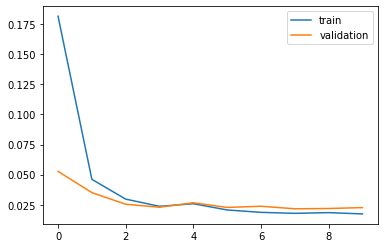

In [ ]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()

## Visualize Predictions on Test

In [ ]:
y_pred = model_lstm.predict(X_test)

In [ ]:
y_pred[0]

array([-0.21473143, -0.14071669, -0.27862   , -0.13825135, -0.15528846,
        0.08161166,  0.42097366,  0.54171705,  0.7723837 ,  0.8499323 ,
        0.8728542 ,  0.95140666,  0.9186668 ,  0.89193285,  0.8145244 ,
        0.6751889 ,  0.42047304,  0.36626145,  0.16156654,  0.09926751,
        0.08352461, -0.00570822, -0.04801938, -0.09996086, -0.14772776,
       -0.18685377, -0.21788949, -0.2265085 , -0.14923558,  0.04583592,
        0.3274327 ,  0.5947003 ,  0.7964503 ,  0.9217287 ,  0.9668684 ,
        0.97884524,  0.9939802 ,  1.008699  ,  0.8412735 ,  0.726302  ,
        0.5135515 ,  0.3257659 ,  0.26482302,  0.1399088 ,  0.06123011,
        0.08598013,  0.00436423, -0.00906613, -0.12415971, -0.15571849,
       -0.26898655, -0.30299586, -0.29164705, -0.02314472,  0.21456617,
        0.54008204,  0.71978116,  0.7912416 ,  0.8653506 ,  0.91278476,
        0.89073056,  0.8798383 ,  0.77564037,  0.6362282 ,  0.40015072,
        0.24407308,  0.10488544,  0.07732382, -0.02000692, -0.00

In [ ]:
len(y_test[0])

288

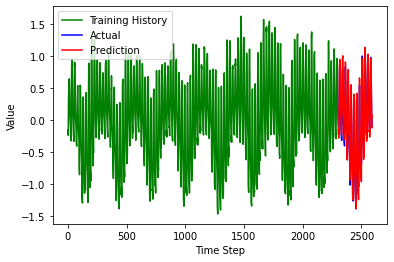

In [ ]:
plt.plot(np.arange(0, len(y_train[:,0])), y_train[:,0], 'g', label="Training History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test[0])), y_test[0], 'b', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test[0])), y_pred[0], 'r', label="Prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Inversing the transformation

In [ ]:
X_test[-1]

array([[-1.52696938e-01,  4.36000000e+02,  3.15225806e+01, ...,
         8.66025404e-01,  0.00000000e+00,  1.00000000e+00],
       [-1.87497791e-01,  4.40129032e+02,  3.98129032e+01, ...,
         8.66025404e-01,  2.69796771e-01,  9.62917287e-01],
       [-2.23412083e-01,  4.65483871e+02,  3.86935484e+01, ...,
         8.66025404e-01,  5.19583950e-01,  8.54419405e-01],
       ...,
       [-1.09770357e-01,  3.38387097e+02,  4.30967742e+01, ...,
         1.00000000e+00, -5.19583950e-01,  8.54419405e-01],
       [-1.34337059e-01,  3.21354839e+02,  4.89516129e+01, ...,
         1.00000000e+00, -2.69796771e-01,  9.62917287e-01],
       [-1.78234937e-01,  3.01838710e+02,  4.43741936e+01, ...,
         1.00000000e+00, -2.44929360e-16,  1.00000000e+00]])

In [ ]:
X_test.shape

(1, 288, 14)

In [ ]:
#y_pred = model_lstm.predict(test_df_scaled_np[24 * 12:24 * 12 *2].reshape(1, 288, 14))
#y_pred = model_lstm.predict(train_df_scaled_np[-24 * 12 :].reshape(1, 288, 14))
y_pred = model_lstm.predict(X_test.reshape(1, 288, 14))
y_pred_inv = temp_transformer.inverse_transform(y_pred)
y_pred_inv = y_pred_inv.reshape(288)

In [ ]:
y_pred.shape

(1, 288)

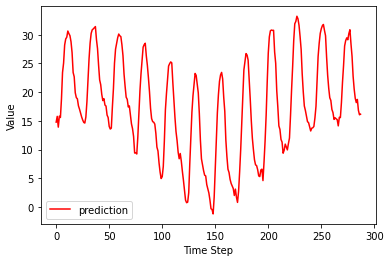

In [ ]:
plt.plot(y_pred_inv, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

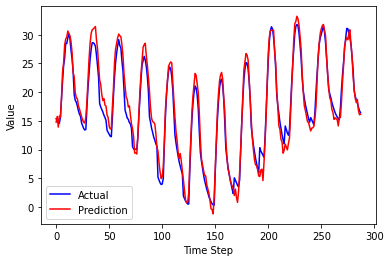

In [ ]:
y_val_inv = temp_transformer.inverse_transform(y_test)
#y_val_inv = y_val_inv[:,0]
y_val_inv = y_val_inv[0]

plt.plot(y_val_inv, 'b', label="Actual")
plt.plot(y_pred_inv, 'r', label="Prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

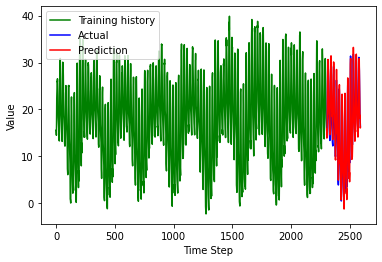

In [ ]:
y_train_inv = temp_transformer.inverse_transform(y_train)
y_train_inv = y_train_inv[:,0]

plt.plot(np.arange(0, len(y_train_inv)), y_train_inv, 'g', label="Training history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred[0])), y_val_inv, 'b', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred[0])), y_pred_inv, 'r', label="Prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

## Calculate Key Error Metrics

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
rmse_lstm = rmse(y_val_inv, y_pred_inv)
mape_lstm = mape(y_val_inv, y_pred_inv)
print (f"RMSE: {rmse_lstm}")
print (f"MAPE: {mape_lstm}")

# another test statistic (mean avg error)
print("MAE: {:.2f}".format(abs(y_val_inv - y_pred_inv).mean()))

RMSE: 1.6915842291979135
MAPE: 17.200148344821276
MAE: 1.38


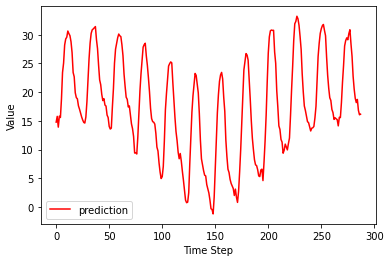

In [ ]:
from keras.models import load_model, model_from_json

with open('{}_model.json'.format(target_city), 'r') as json_file:
    model = model_from_json(json_file.read())

model.load_weights('{}_model.h5'.format(target_city))

model.compile(loss= "mean_squared_error", optimizer='adam', metrics=["accuracy"])

y_pred = model.predict(X_test.reshape(1, 288, 14))
y_pred_inv = temp_transformer.inverse_transform(y_pred)
y_pred_inv = y_pred_inv.reshape(288)

plt.plot(y_pred_inv, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

np.savetxt("{}_predictons.csv".format(target_city), y_pred_inv , delimiter=",")